<a href="https://colab.research.google.com/github/willpanderson/Auto-Learn/blob/master/Machine%20Learning/TF_Model/Separate_Testing_Validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
 
from __future__ import absolute_import, division, print_function, unicode_literals
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
import numpy as np
import pandas as pd
import traceback
import textwrap


In [0]:
pd.set_option("display.precision", 8)

In [4]:
# Mount the Google drive to get access to the data
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
# Set the root directory of the data
data_root='/content/drive/My Drive/TFLITE/car_images'

In [7]:
# Set up data generators with an 80/20 Testing/Validation split. The generators will be used
# to cycle through the data in batches for training.
IMAGE_SHAPE = (224, 224) # Image size
TRAINING_DATA_DIR = str(data_root) 
print(TRAINING_DATA_DIR);
datagen_kwargs = dict(rescale=1./255, validation_split=.20) # Validation split .2 = 20% validation
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs) # Use Tensorflows ImageDataGenerator
valid_generator = valid_datagen.flow_from_directory(
TRAINING_DATA_DIR, 
subset="validation", # 20% of input images
batch_size = 128,
shuffle=True, # Mix them up with every run through
target_size= IMAGE_SHAPE
)
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs) # Use Tensorflows ImageDataGenerator
train_generator = train_datagen.flow_from_directory(
TRAINING_DATA_DIR,
subset="training", # 80% of input images
batch_size = 128,
shuffle=True, # Mix with every run through 
target_size=IMAGE_SHAPE)

/content/drive/My Drive/TFLITE/car_images
Found 1129 images belonging to 6 classes.
Found 4531 images belonging to 6 classes.


In [8]:
image_batch_train, label_batch_train = next(iter(train_generator)) # Iterate through the batches with the generator above
print("Image batch shape: ", image_batch_train.shape)
print("Label batch shape: ", label_batch_train.shape)
dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

Image batch shape:  (128, 224, 224, 3)
Label batch shape:  (128, 6)
['Convertible' 'Coupe' 'Sedan' 'Suv' 'Truck' 'Van']


In [9]:
# Define the model
model = tf.keras.Sequential([
hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", 
output_shape=[1280],
trainable=False),
tf.keras.layers.Dropout(0.4),    # 1 Dropout layer and 3 Dense layers were used in lieu of 
Dense(256, activation = 'relu'), # Convolutions and MaxPooling layers due to issues when it
Dense(128, activation = 'relu'), # Came to the shape of the data after running through the model
Dense(6, activation = 'softmax') # We used multiple Dense layers instead to increase Trainable Params
])

# Build and compile the model using the Adam optimizer
model.build([None, 224, 224, 3])
model.summary()
model.compile(
optimizer=tf.keras.optimizers.Adam(),
loss='categorical_crossentropy',
metrics=['acc'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  2257984   
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  327936    
_________________________________________________________________
dense_1 (Dense)              multiple                  32896     
_________________________________________________________________
dense_2 (Dense)              multiple                  774       
Total params: 2,619,590
Trainable params: 361,606
Non-trainable params: 2,257,984
_________________________________________________________________


In [42]:
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size) # Steps = number of samples/batch size(defined in the generators)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)
hist = model.fit(
train_generator,
epochs=10, # Set epochs. Since this portion is celled on Collab, can run multiple times to stack epochs of different counts
verbose=1,
steps_per_epoch=steps_per_epoch,
validation_data=valid_generator,
validation_steps=val_steps_per_epoch).history


 1/36 [..............................] - ETA: 0s - loss: 0.1382 - acc: 0.9531

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


16/36 [============>.................] - ETA: 23s - loss: 0.1453 - acc: 0.9442

KeyboardInterrupt: ignored

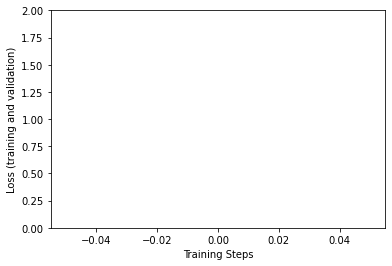

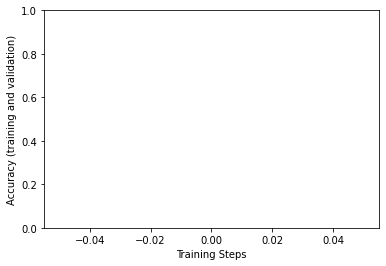

In [43]:
# Plot data to help visualize accuracy and loss
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])

In [17]:
# When desired accuracy/loss is reached, can run this cell to save the model to a drive folder
CAR_SAVED_MODEL = "/content/drive/My Drive/TFLITE/Saved_Model"
tf.saved_model.save(model, CAR_SAVED_MODEL)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: /content/drive/My Drive/TFLITE/Saved_Model/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/TFLITE/Saved_Model/assets


In [44]:
# Load Saved_Model to test
CAR_SAVED_MODEL = "/content/drive/My Drive/TFLITE/Saved_Model"
car_model = hub.load(CAR_SAVED_MODEL)
print(car_model)

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f94f12821d0>


In [45]:
# Get images and labels batch from validation dataset generator

val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)

print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (128, 224, 224, 3)


In [46]:
tf_model_predictions = car_model(val_image_batch)
print("Prediction results shape:", tf_model_predictions.shape)

Prediction results shape: (128, 6)


In [47]:
# Convert prediction results to Pandas dataframe, for better visualization

tf_pred_dataframe = pd.DataFrame(tf_model_predictions.numpy())
tf_pred_dataframe.columns = dataset_labels

print("Prediction results for the first elements")
tf_pred_dataframe.head()

Prediction results for the first elements


,Convertible,Coupe,Sedan,Suv,Truck,Van
0,0.00070474,0.04003951,0.80703419,0.13011578,0.00010333,0.02200237
1,0.05090849,0.05442331,0.38836727,0.39982727,0.10513533,0.00133841
2,0.00211929,0.32475948,0.63908142,0.03378640,0.00000634,0.00024695
3,0.53021479,0.46764097,0.00208142,0.00004960,0.00000015,0.00001307
4,0.00385198,0.72088242,0.26854354,0.00658365,0.00000578,0.00013265


In [0]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]

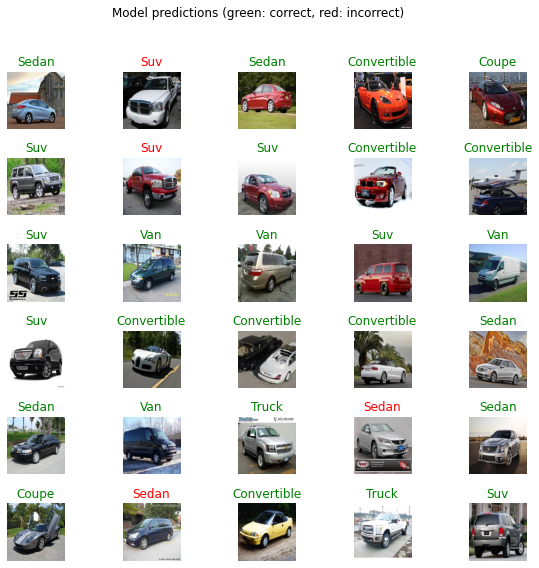

In [49]:
# Print images batch and labels predictions

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [0]:
!mkdir "/content/drive/My Drive/TFLITE/tflite_models"
TFLITE_MODEL = "/content/drive/My Drive/TFLITE/tflite_models/TFLiteModel.tflite"
TFLITE_QUANT_MODEL = "/content/drive/My Drive/TFLITE/tflite_models/TFLiteModel_quant.tflite"
model = tf.keras.applications.MobileNetV2(weights="imagenet", input_shape=(224, 224, 3))
run_model = tf.function(lambda x: model(x))
concrete_func = run_model.get_concrete_function(tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype))

In [54]:
# Convert the model to TFLite
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converted_tflite_model = converter.convert()
open(TFLITE_MODEL, "wb").write(converted_tflite_model)
# Convert the model to quantized version with post-training quantization
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_quant_model = converter.convert()
open(TFLITE_QUANT_MODEL, "wb").write(tflite_quant_model)
print("TFLite models and their sizes:")
!ls "/content/drive/My Drive/TFLITE/tflite_models" -lh

TFLite models and their sizes:
ls: cannot access 'tflite_models': No such file or directory
